# SN-E2

In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline

import halomod as hm
import hmf


#%matplotlib inline
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
#plt.rc('font',**{'family':'serif','size':18})
#plt.rc('text', usetex=True)

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# My catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits")  
t= Table.read(fits_file_path)
masked = os.path.join(thesis_path, "SN-E2_masked_cat.fits")  

t3= Table.read(masked)


t=join(t,t3,keys='id') # joined table


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')



#Randoms
fits_random = os.path.join(thesis_path, "SN-E2_randoms_ugriz_trim_video.fits") 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)
randoms = t2



Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-E2_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-E2_C01_randoms_raw.fits    1 BinTableHDU     18   11025433R x 3C   [E, E, 9A]   


In [3]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


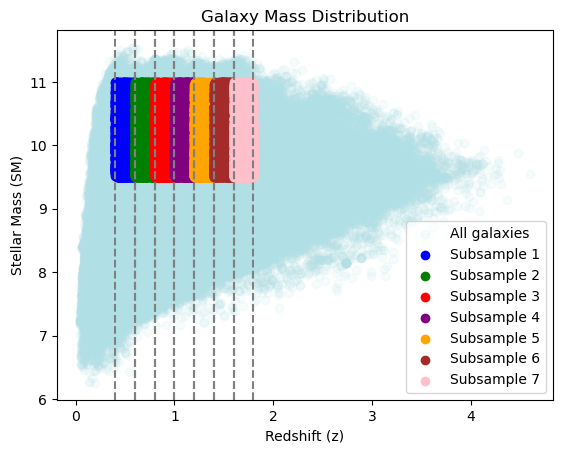

Subsample 1: N = 6351
  z_mean: 0.5
  SM_mean: 10.25
  z_min: 0.4

Subsample 2: N = 6447
  z_mean: 0.7
  SM_mean: 10.25
  z_min: 0.6

Subsample 3: N = 9140
  z_mean: 0.9
  SM_mean: 10.25
  z_min: 0.8

Subsample 4: N = 8218
  z_mean: 1.1
  SM_mean: 10.25
  z_min: 1.0

Subsample 5: N = 7636
  z_mean: 1.2999999999999998
  SM_mean: 10.25
  z_min: 1.2

Subsample 6: N = 5970
  z_mean: 1.5
  SM_mean: 10.25
  z_min: 1.4

Subsample 7: N = 6454
  z_mean: 1.7000000000000002
  SM_mean: 10.25
  z_min: 1.6



In [4]:
class Subsample:
    def __init__(self, z_min, z_max, SM_min, SM_max):
        self.z_min = z_min
        self.z_max = z_max
        self.SM_min = SM_min
        self.SM_max = SM_max
        self.info = {}  # Empty dictionary to store information

        # Add relevant information for R_0 calculation (e.g., delta, A, delta_z)
        self.info['delta'] = None  # Placeholder for delta
        self.info['A'] = None  # Placeholder for A
        # self.info['A'] = np.zeros()
        self.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        
       

    def apply(self, data):
        """
        Selects data points within the subsample region.

        Args:
            data: A dictionary containing data columns like 'z' and 'SM'.

        Returns:
            A boolean mask for the subsample selection.
        """
        return (data['z'] > self.z_min) & (data['z'] <= self.z_max) & \
               (data['SM'] > self.SM_min) & (data['SM'] <= self.SM_max)
    
    
    
# Define z and SM ranges
z_values = np.array([ 0.4,0.6,0.8, 1.0, 1.2, 1.4,1.6,1.8])

SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM

#SM_range = np.linspace(8, 11, num=4) # diff Sm



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = Subsample(z_min, z_max, SM_min, SM_max)
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',color='powderblue',alpha=0.1)

# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']
num_colors = len(colors)


for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i % num_colors])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

In [5]:

class CorrelationFunction:
    def __init__(self, cat, randoms, config, rr=None):
        self.cat = cat
        self.randoms = randoms
        self.config = config

        # Create TreeCorr catalogs
        self.data = treecorr.Catalog(ra=cat['ra'], dec=cat['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)
        self.rand = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)

        # Create TreeCorr correlation functions
        self.dd = treecorr.NNCorrelation(**config)
        self.rr = treecorr.NNCorrelation(**config)
        self.dr = treecorr.NNCorrelation(**config)
        
    #def process_rand(self):
        #self.rr.process(self.rand) ###????maybe here problem?

    def process(self):
        self.dd.process(self.data)
        self.dr.process(self.data, self.rand)
        self.rr.process(self.rand)

    def calculate_w_theta(self):
        theta = np.exp(self.dd.meanlogr)
        w, varw = self.dd.calculateXi(rr=self.rr, dr=self.dr) 
        
        return w, varw, theta , self.rr

In [6]:
# Create CorrelationFunction objects with the same configuration
corr_funcs = []

#for i, catalog in enumerate(catalogs):
for i, subsample in enumerate(subsamples):

    corr_func = CorrelationFunction(catalog, randoms, config)
    corr_func.process()
    w, varw, theta, rr = corr_func.calculate_w_theta()

    # Append the calculated values to the corresponding subsample's info dictionary
    subsamples[i].info['w'] = w
    subsamples[i].info['varw'] = varw
    subsamples[i].info['theta'] = theta
    subsamples[i].info['rr'] = rr
    corr_funcs.append(corr_func)

In [7]:
"""for i, subsample in enumerate(subsamples):
    plt.scatter( subsample.info['theta'], subsample.info['w'], label=f"Subsample {i+1}")
    plt.xlabel(r' $ \theta$ (degrees)')  #correlation function w
    plt.ylabel(r' $w(\theta)$') # angular separation theta
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)

    plt.show()"""

'for i, subsample in enumerate(subsamples):\n    plt.scatter( subsample.info[\'theta\'], subsample.info[\'w\'], label=f"Subsample {i+1}")\n    plt.xlabel(r\' $ \theta$ (degrees)\')  #correlation function w\n    plt.ylabel(r\' $w(\theta)$\') # angular separation theta\n    plt.legend()\n    plt.yscale(\'log\')\n    plt.xscale(\'log\')\n    plt.grid(True)\n\n    plt.show()'

Subsample 1, Power-law Fit Parameters
 Amplitude at 1°: 0.0013190816501532476
 Delta: -0.9131400951321039

Subsample 2, Power-law Fit Parameters
 Amplitude at 1°: 0.0013467185038963003
 Delta: -0.909145508511236

Subsample 3, Power-law Fit Parameters
 Amplitude at 1°: 0.0013559667094423333
 Delta: -0.9074845323395475

Subsample 4, Power-law Fit Parameters
 Amplitude at 1°: 0.0013245829847432194
 Delta: -0.9125276586873505

Subsample 5, Power-law Fit Parameters
 Amplitude at 1°: 0.001302826660374303
 Delta: -0.9156921515370515

Subsample 6, Power-law Fit Parameters
 Amplitude at 1°: 0.0013419797813960526
 Delta: -0.9097678525342592

Subsample 7, Power-law Fit Parameters
 Amplitude at 1°: 0.0013100302278695936
 Delta: -0.9146556330223533



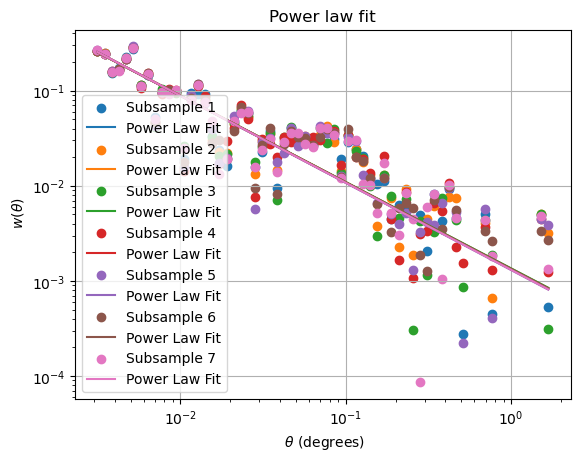

In [8]:
def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
    """
    Fits a power law to the provided 2PCF data and plots the results.

    Args:
        theta (np.ndarray): Angular separation bins.
        w (np.ndarray): 2PCF values for the current catalog.
        cat (int): Identifier for the current catalog (used for labeling).
    """

    # Fit the power law using curve_fit with initial guesses
    #popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])
    popt, pcov = curve_fit(power_law, subsample.info['theta'], subsample.info['w'], p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print(f" Delta:", delta_fit)
    print()

    # Plot the data and fitted curve for this catalog
    #plt.scatter(theta, w, label=f"Subsample {cat}")
    #plt.plot(theta, power_law(theta, *popt), label='Power Law Fit')
    
    plt.scatter(subsample.info['theta'], subsample.info['w'], label=f"Subsample {cat}")
    plt.plot(subsample.info['theta'], power_law(subsample.info['theta'], *popt), label='Power Law Fit')


    return amplitude_at_1deg, delta_fit

    
#deltas = []
#As = []
for i, subsample in enumerate(subsamples):
 
    A, delta = fit_and_plot_power_law(subsamples[i].info['theta'][i], subsamples[i].info['w'], i + 1)
    subsamples[i].info['A'] = A
    subsamples[i].info['delta'] = delta
    

    #As.append(A)
    #deltas.append(delta)
    
    
    

# Additional plotting customizations (labels, grid, etc.) can be added here
plt.title("Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.savefig("Power law fit")

plt.grid(True)
plt.legend()
plt.show()

In [9]:
print(subsample.info['A'])
print(subsample.info['delta'])

0.0013100302278695936
-0.9146556330223533


In [10]:
class Cosmology:
    def __init__(self, H0, Omega0):
        self.H0 = H0
        self.Omega0 = Omega0

    def x(self, z):
        def integrand(z_prime):
            return ((1 + z_prime)**3 + self.Omega0 - 1)**(-0.5)
        result, _ = quad(integrand, 0, z)
        return result * (self.Omega0**(-0.5) * self.H0)

    def F(self, z):
        return 1

    def P(self, z):
        return np.sqrt(self.Omega0) * np.sqrt((1 + z) ** 3 + self.Omega0**(-1) - 1)

In [11]:
# class that calculates the comoving correlation length (R_0) for a subsample based on its properties

class SubsampleAnalysis:
    def __init__(self, delta, A, z_mean, delta_z, H_gamma=3.68, c=299792.458):
        self.delta = delta
        self.A = A
        self.z_mean = z_mean
        self.delta_z = delta_z
        self.H_gamma = H_gamma
        self.c = c

        # Assuming a standard cosmology
        self.cosmo = Cosmology(H0=70, Omega0=0.3)

    def calculate_r0(self):
        print(type(self.A))
        gamma = 1.8
        #gamma = (self.delta * -1) + 1
        print(gamma)
        numerator = self.c * self.A * self.delta_z

        denominator = self.cosmo.H0 * self.H_gamma * self.cosmo.x(self.z_mean) ** (1 - gamma) * self.cosmo.P(self.z_mean) * self.cosmo.F(self.z_mean)
        r0 = (numerator / denominator) ** (1 / gamma)
        
        return r0

In [12]:
r0_values = []
for subsample in subsamples:
    # Create a SubsampleAnalysis object with relevant information
    analysis = SubsampleAnalysis(subsample.info['delta'], subsample.info['A'],
                                  subsample.info['z_mean'], subsample.info['delta_z'] ,3.68, 299792.458)

    # Calculate R_0 for the subsample
    r0 = analysis.calculate_r0()
    #r0_values.append(r0)
    
    
    #r0_value = r0[0]  # Assuming r0 is a 1D array, access the first element
    r0_values.append(r0)
    


<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8


In [13]:

nz = hm.integrate_corr.flat_z_dist(0.4, 1.8)
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=0.4,zmax=1.8,z=1.1)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
#gg.theta_min = np.min(thetas[0])*np.pi/180
#gg.theta_max = np.max(thetas[0])*np.pi/180
#gg.theta_num = len(thetas[0])

gg.theta_min = np.min(subsample.info['theta'][0])*np.pi/180
gg.theta_max = np.max(subsample.info['theta'][0])*np.pi/180

print(gg.angular_corr_gal)

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


[0.37346785 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785
 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785
 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785
 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785
 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785 0.37346785]


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


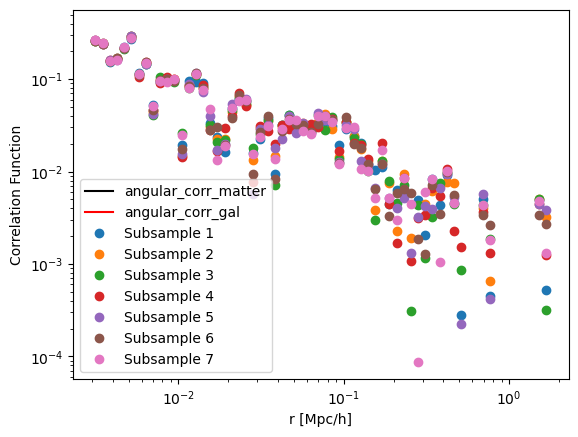

In [14]:
for i, subsample in enumerate(subsamples):
    
    #plt.errorbar(thetas[i],ws[i], fmt='o', label=f"Subsample {i+1}")#'without IC
    plt.errorbar(subsample.info['theta'], subsample.info['w'],  fmt='o',label=f"Subsample {i+1}")

plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')


plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [15]:

# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)

In [16]:


# Define the directory where you want to save the file
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 

# Create the directory if it doesn't exist
os.makedirs(directory_SN_E2, exist_ok=True) 




In [17]:
"""

diff_sm_biases = []


for i, subsample in enumerate(subsamples):


    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, subsample.info['w'][:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    diff_sm_bias = popt[0]
    diff_sm_bias_error = np.sqrt(pcov[0, 0])

    # Print SM_mean for reference
    print(f"Subsample {i+1} SM_mean: {subsample.info['SM_mean']:.3f}")

    # Append SM_mean, bias, and error to a list
    diff_sm_biases.append([subsample.info['SM_mean'], diff_sm_bias, diff_sm_bias_error])
    print(f"Bias: {diff_sm_bias:.3f} +/- {diff_sm_bias_error:.3f}")

# Create a NumPy array from the list of lists (modified for 3 columns)
diff_sm_bias_array = np.array(diff_sm_biases)

# Construct the full file path
file_path = os.path.join(directory_SN_E2, "diff_sm_biases.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(file_path, diff_sm_bias_array, delimiter=',', fmt='%.3f')


# Load the data from the text file
diff = np.loadtxt(file_path, delimiter=',')

# Extract SM_mean, bias, and error values from the loaded data
sm_means = diff[:, 0]
diff_biases = diff[:, 1]
diff_errors = diff[:, 2]"""

'\n\ndiff_sm_biases = []\n\n\nfor i, subsample in enumerate(subsamples):\n\n\n    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, subsample.info[\'w\'][:len(gg.angular_corr_matter)], p0=[2.0])\n\n    # Extract the best-fit bias parameter and error\n    diff_sm_bias = popt[0]\n    diff_sm_bias_error = np.sqrt(pcov[0, 0])\n\n    # Print SM_mean for reference\n    print(f"Subsample {i+1} SM_mean: {subsample.info[\'SM_mean\']:.3f}")\n\n    # Append SM_mean, bias, and error to a list\n    diff_sm_biases.append([subsample.info[\'SM_mean\'], diff_sm_bias, diff_sm_bias_error])\n    print(f"Bias: {diff_sm_bias:.3f} +/- {diff_sm_bias_error:.3f}")\n\n# Create a NumPy array from the list of lists (modified for 3 columns)\ndiff_sm_bias_array = np.array(diff_sm_biases)\n\n# Construct the full file path\nfile_path = os.path.join(directory_SN_E2, "diff_sm_biases.txt")\n\n# Save the array using delimiter for each column (modified for 3 columns)\nnp.savetxt(file_path, diff_sm_bias_array, delimit

In [21]:


high_sm_biases = []


for i, subsample in enumerate(subsamples):


    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, subsample.info['w'][:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    high_sm_bias = popt[0]
    high_sm_bias_error = np.sqrt(pcov[0, 0])

    # Print SM_mean for reference
    print(f"Subsample {i+1} SM_mean: {subsample.info['SM_mean']:.3f}")

    # Append SM_mean, bias, and error to a list
    high_sm_biases.append([subsample.info['SM_mean'], high_sm_bias, high_sm_bias_error])
    print(f"Bias: {high_sm_bias:.3f} +/- {high_sm_bias_error:.3f}")

# Create a NumPy array from the list of lists (modified for 3 columns)
high_sm_bias_array = np.array(high_sm_biases)

# Construct the full file path
file_path = os.path.join(directory_SN_E2, "high_sm_biases.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(file_path, high_sm_bias_array, delimiter=',', fmt='%.3f')


# Load the data from the text file
high = np.loadtxt(file_path, delimiter=',')

# Extract SM_mean, bias, and error values from the loaded data
sm_means = high[:, 0]
high_biases = high[:, 1]
high_errors = high[:, 2]

Subsample 1 SM_mean: 10.250
Bias: 1.812 +/- 0.143
Subsample 2 SM_mean: 10.250
Bias: 1.812 +/- 0.145
Subsample 3 SM_mean: 10.250
Bias: 1.811 +/- 0.144
Subsample 4 SM_mean: 10.250
Bias: 1.811 +/- 0.146
Subsample 5 SM_mean: 10.250
Bias: 1.811 +/- 0.147
Subsample 6 SM_mean: 10.250
Bias: 1.811 +/- 0.145
Subsample 7 SM_mean: 10.250
Bias: 1.811 +/- 0.144


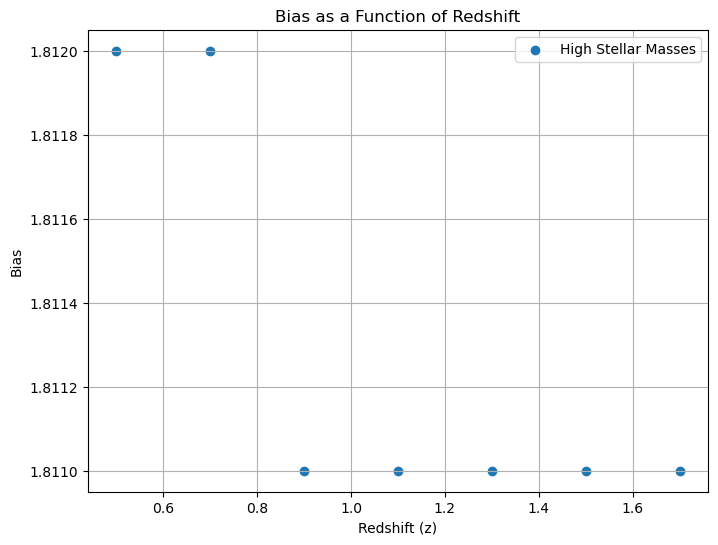

In [22]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]

# Plot bias vs. redshift

#plt.errorbar(redshifts, L_biases, label='Low Stellar Mass ',marker='o') # 8 to 9.5
#plt.errorbar(redshifts, H_biases, label='High Stellar Mass',marker='o') #9.5 to 11
#plt.scatter(redshifts, diff_biases, label='Different Stellar Masses',marker='o')
plt.scatter(redshifts, high_biases, label='High Stellar Masses',marker='o')

plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

plt.savefig(os.path.join(directory_SN_E2,"Bias as a Function of Redshift for High SM"))

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

In [23]:
diff = np.loadtxt(file_path, delimiter=',')
print(diff)

[[10.25   1.812  0.143]
 [10.25   1.812  0.145]
 [10.25   1.811  0.144]
 [10.25   1.811  0.146]
 [10.25   1.811  0.147]
 [10.25   1.811  0.145]
 [10.25   1.811  0.144]]


In [24]:
#m = SM_mean_range
m = np.unique(SM_mean_range) # Get the unique SM values

z= z_mean_range
print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)
zm=np.array(zm).reshape(2,-1)
zm[:,0]

r0s_reshaped = np.reshape(r0_values, (len(z), len(m))).T  # since r0s is a flattened array


len(m): 1
len(z): 7


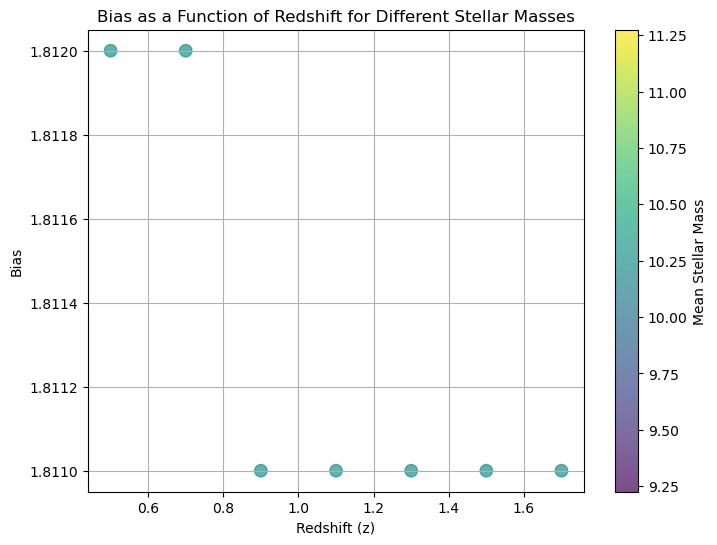

In [25]:

# Extract z_mean and bias values from the loaded data
diff_biases = diff[:, 1]  # Assuming bias is in the second column
sm_means = diff[:, 0]  # Assuming SM_mean is in the first column

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(redshifts, diff_biases, c=sm_means, cmap='viridis', s=80, alpha=0.7)
plt.colorbar(label='Mean Stellar Mass')
plt.xlabel('Redshift (z)')
plt.ylabel('Bias')
plt.title('Bias as a Function of Redshift for Different Stellar Masses')
#plt.savefig(directory_SN_E2,"Bias_vs_redshift_for_diff_SM_SN-E2.png") 
plt.savefig(os.path.join(directory_SN_E2, "Bias_vs_redshift_for_diff_SM_SN-E2.png"))


plt.grid(True)
plt.show()

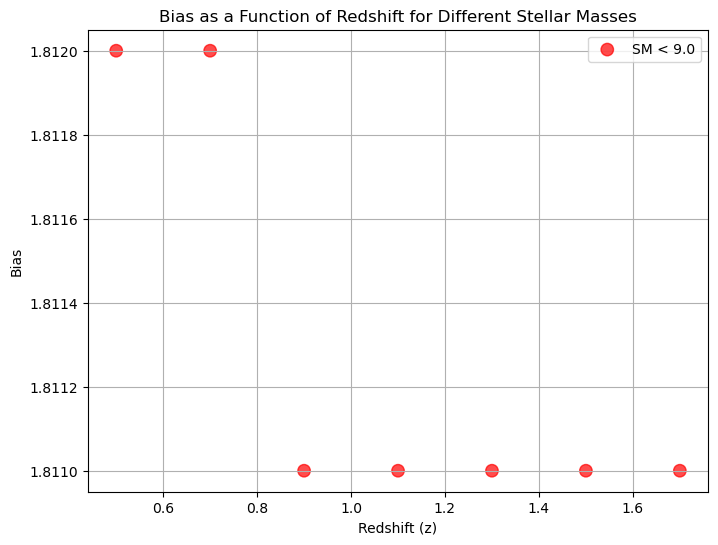

In [26]:

# Extract z_mean and bias values from the loaded data
diff_biases = diff[:, 1]  # Assuming bias is in the second column
sm_means = diff[:, 0]  # Assuming SM_mean is in the first column

# Define a function to assign colors based on SM_mean
def get_color(sm):
    if sm < 9.0:
        return 'b'
    elif sm < 10.0:
        return 'g'
    else:
        return 'r'

# Create a list of colors based on SM_mean values
colors = [get_color(sm) for sm in sm_means]
legend_labels = ['SM < 9.0', '9.0 <= SM < 10.0', 'SM >= 10.0']


# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(redshifts, diff_biases, c=colors, s=80, alpha=0.7)
plt.xlabel('Redshift (z)')
plt.ylabel('Bias')
plt.title('Bias as a Function of Redshift for Different Stellar Masses')
plt.legend(legend_labels)  
plt.grid(True)
plt.savefig(os.path.join(directory_SN_E2, "Bias_vs_redshift_for_diff_SM_SN-E2.png"))

plt.show()

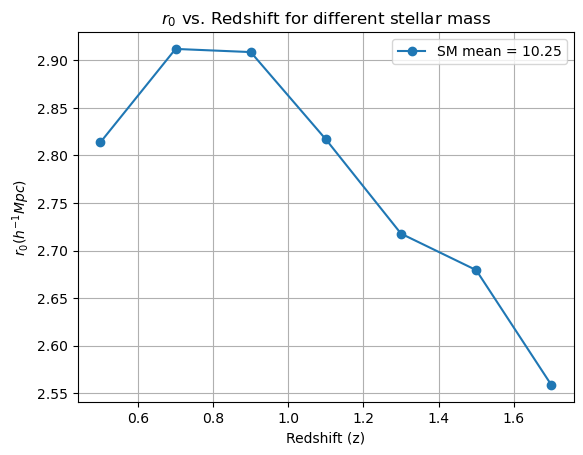

In [27]:
sm_means = [subsample.info['SM_mean'] for subsample in subsamples]

for i in range(len(m)):
    # Plot R_0 as a function of z_mean
    sigma = [0.1 * z_mean + 1 for z_mean in z]  # is the rms error on each redshift

    #plt.scatter(redshifts, r0_values, label=f"SM = {m[i]:.1f}", c=colors,s=80, alpha=0.7)
    #plt.errorbar(z, r0s_reshaped[i], yerr=sigma,label=f"SM = {m[i]:.1f}", marker='o',capsize=7,)
    plt.plot(z, r0s_reshaped[i], label=f"SM mean = {m[i]:.2f}",marker='o')


    

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift for different stellar mass")
plt.grid(True)
#plt.savefig(os.path.join(directory_SN_E2, "r0_vs_z_for_diff_SM_SN-E2.png"))
#legend_labels = ['SM < 9.0 BLUE', '9.0 <= SM < 10.0 GREEN', 'SM >= 10.0 RED']
#plt.legend(legend_labels)

plt.savefig(os.path.join(directory_SN_E2, "r0_vs_z_for_high_SM_SN-E2.png"))
plt.legend()

plt.show()

In [50]:
import csv  # Import the csv module for convenient text file writing

results = []

for i, subsample in enumerate(subsamples):
    # Create a list/tuple to hold data for the current subsample
    subsample_data = [subsample.info['SM_mean'], subsample.info['z_mean'], high_biases[i], r0_values[i]]

    # Append the subsample data to the results list
    results.append(subsample_data)

# Save the results to a text file with appropriate headers
with open('/home/astro/manasoi7/Master_Thesis/Results/SN-E2/subsamples_info_SN-E2.txt', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['SM_mean', 'z_mean', 'high_biases', 'r0_values'])  # Write headers
    writer.writerows(results)  # Write each subsample data as a row



In [54]:

# Create a NumPy array from the list of lists (modified for 3 columns)
#results_array = np.array(results)

# Construct the full file path
c = os.path.join(directory_SN_E2, "subsamples_info_SN-E2.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(c, results, delimiter=',', fmt='%.3f')


# Load the data from the text file
E2 = np.loadtxt(c, delimiter=',')

In [55]:
print(E2)

[[10.25   0.5    1.812  2.814]
 [10.25   0.7    1.812  2.912]
 [10.25   0.9    1.811  2.909]
 [10.25   1.1    1.811  2.817]
 [10.25   1.3    1.811  2.718]
 [10.25   1.5    1.811  2.68 ]
 [10.25   1.7    1.811  2.559]]


In [57]:

# Define the directory where you want to save the file
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3" 

# Create the directory if it doesn't exist
os.makedirs(directory_SN_C3, exist_ok=True) 

In [60]:
# Construct the full file path
c = os.path.join(directory_SN_C3, "subsamples_info_SN-C3.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(c, results, delimiter=',', fmt='%.3f')


# Load the data from the text file
C3 = np.loadtxt(c, delimiter=',')

In [61]:
print(C3)

[[10.25   0.5    1.812  2.814]
 [10.25   0.7    1.812  2.912]
 [10.25   0.9    1.811  2.909]
 [10.25   1.1    1.811  2.817]
 [10.25   1.3    1.811  2.718]
 [10.25   1.5    1.811  2.68 ]
 [10.25   1.7    1.811  2.559]]


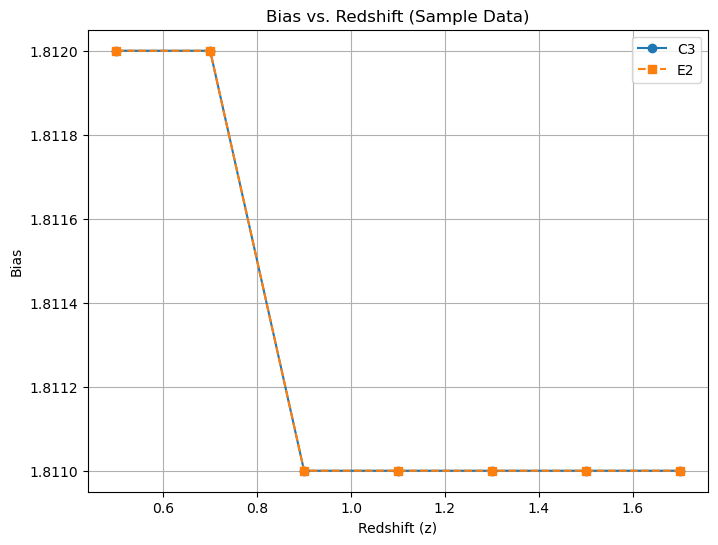

In [62]:
# Create the plot
plt.figure(figsize=(8, 6))  # Set plot size

plt.plot(C3[:, 1], C3[:, 2], label='C3', marker='o', linestyle='-')
plt.plot(E2[:, 1], E2[:, 2], label='E2', marker='s', linestyle='--')

# Customize the plot
plt.xlabel('Redshift (z)')
plt.ylabel('Bias')
plt.title('Bias vs. Redshift (Sample Data)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()